### Retrieve the filenames for car and not-car images and write them to a text file. Also check total number of images provided car and not-car.

In [1]:
import os
import glob

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print("Number of Vehicle Images found: ", len(cars))
with open("cars.txt", "w") as f:
    for fn in cars:
        f.write(fn+"\n")

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
    
print("Number of Non-Vehicle Images found: ", len(notcars))
with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+"\n")

Number of Vehicle Images found:  8792
Number of Non-Vehicle Images found:  8968


### Import all required packages

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### Define all functions

In [3]:
# Function to convert color spaces
def color_spaces(img, color_space='RGB'):
    if(color_space != 'RGB'):
        if(color_space == 'HSV'):
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif(color_space == 'LUV'):
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif(color_space == 'HLS'):
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif(color_space == 'YUV'):
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif(color_space == 'YCrCb'):
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    return feature_image


# Function to compute spatial binning
def bin_spatial(img, size=(32,32)):
    r_channel = cv2.resize(img[:,:,0], size).ravel()
    g_channel = cv2.resize(img[:,:,1], size).ravel()
    b_channel = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((r_channel, g_channel, b_channel))
    

# Function to compute color histogram features
def color_hist(img, nbins=32):
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features


# Function to return HOG features and visualisation
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if(vis == True):
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), visualise=vis,
                              feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), visualise=vis, 
                       feature_vector=feature_vec)
        return features


# Function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32,32), hist_bins=32, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channels=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        
        feature_image = color_spaces(image, color_space=color_space)
        
        if(spatial_feat == True):
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if(hist_feat == True):
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if(hog_feat == True):
            if(hog_channels == 'ALL'):
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                         cell_per_block, vis=False, feature_vec=True ))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channels], orient, pix_per_cell, 
                                                         cell_per_block, vis=False, feature_vec=True )
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))    
    
    return features


# Function to extract features for a single image
def single_img_features(img, color_space='RGB', spatial_size=(32,32), hist_bins=32, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channels=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    
    img_features = []
    feature_image = color_spaces(img, color_space=color_space)
    # feature_image = np.copy(img)

    if(spatial_feat == True):
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if(hist_feat == True):
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if(hog_feat == True):
        if(hog_channels == 'ALL'):
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False, feature_vec=True ))
            hog_features = np.ravel(hog_features)
        else:
            if(vis == True):
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channels], orient, pix_per_cell, 
                                                           cell_per_block, vis=True, feature_vec=True )
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channels], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feature_vec=True )
        img_features.append(hog_features)
    
    if(vis == True):
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
    
# Function to implement sliding window
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if(x_start_stop[0] == None):
        x_start_stop[0] = 0
    if(x_start_stop[1] == None):
        x_start_stop[1] = img.shape[1]
    if(y_start_stop[0] == None):
        y_start_stop[0] = 0
    if(y_start_stop[1] == None):
        y_start_stop[1] = img.shape[0]
    # Compute the span of the image to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Function to draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Function to get the window images and classify
def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, 
                   hog_channels=0, spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channels=hog_channels, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows


# Function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if(img_dims < 3):
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


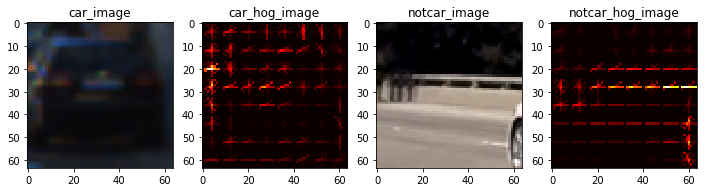

In [4]:
# Choose a random car/not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read a car/not-car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channels = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channels=hog_channels, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                                        orient=orient, pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, hog_channels=hog_channels, 
                                                        spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                        hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car_hog_image', 'notcar_image', 'notcar_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [36]:
# cv2.imwrite('output_images/hog_output/car_image.png', car_image)
# cv2.imwrite('output_images/hog_output/car_hog_image.png', car_hog_image)
# cv2.imwrite('output_images/hog_output/notcar_image.png', notcar_image)
# cv2.imwrite('output_images/hog_output/notcar_hog_image.png', notcar_hog_image)

True

In [5]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channels = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars # np.array(cars)[random_idxs]
test_notcars = notcars # np.array(notcars)[random_idxs]


car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channels=hog_channels, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, 
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channels=hog_channels, 
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up the data into randomised training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


130.13982367515564 Seconds to compute features
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
25.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.7403690814971924 seconds to process one image out of  100  windows
0.7355861663818359 seconds to process one image out of  100  windows
0.7186887264251709 seconds to process one image out of  100  windows
0.7210829257965088 seconds to process one image out of  100  windows
0.7000751495361328 seconds to process one image out of  100  windows
0.7132091522216797 seconds to process one image out of  100  windows


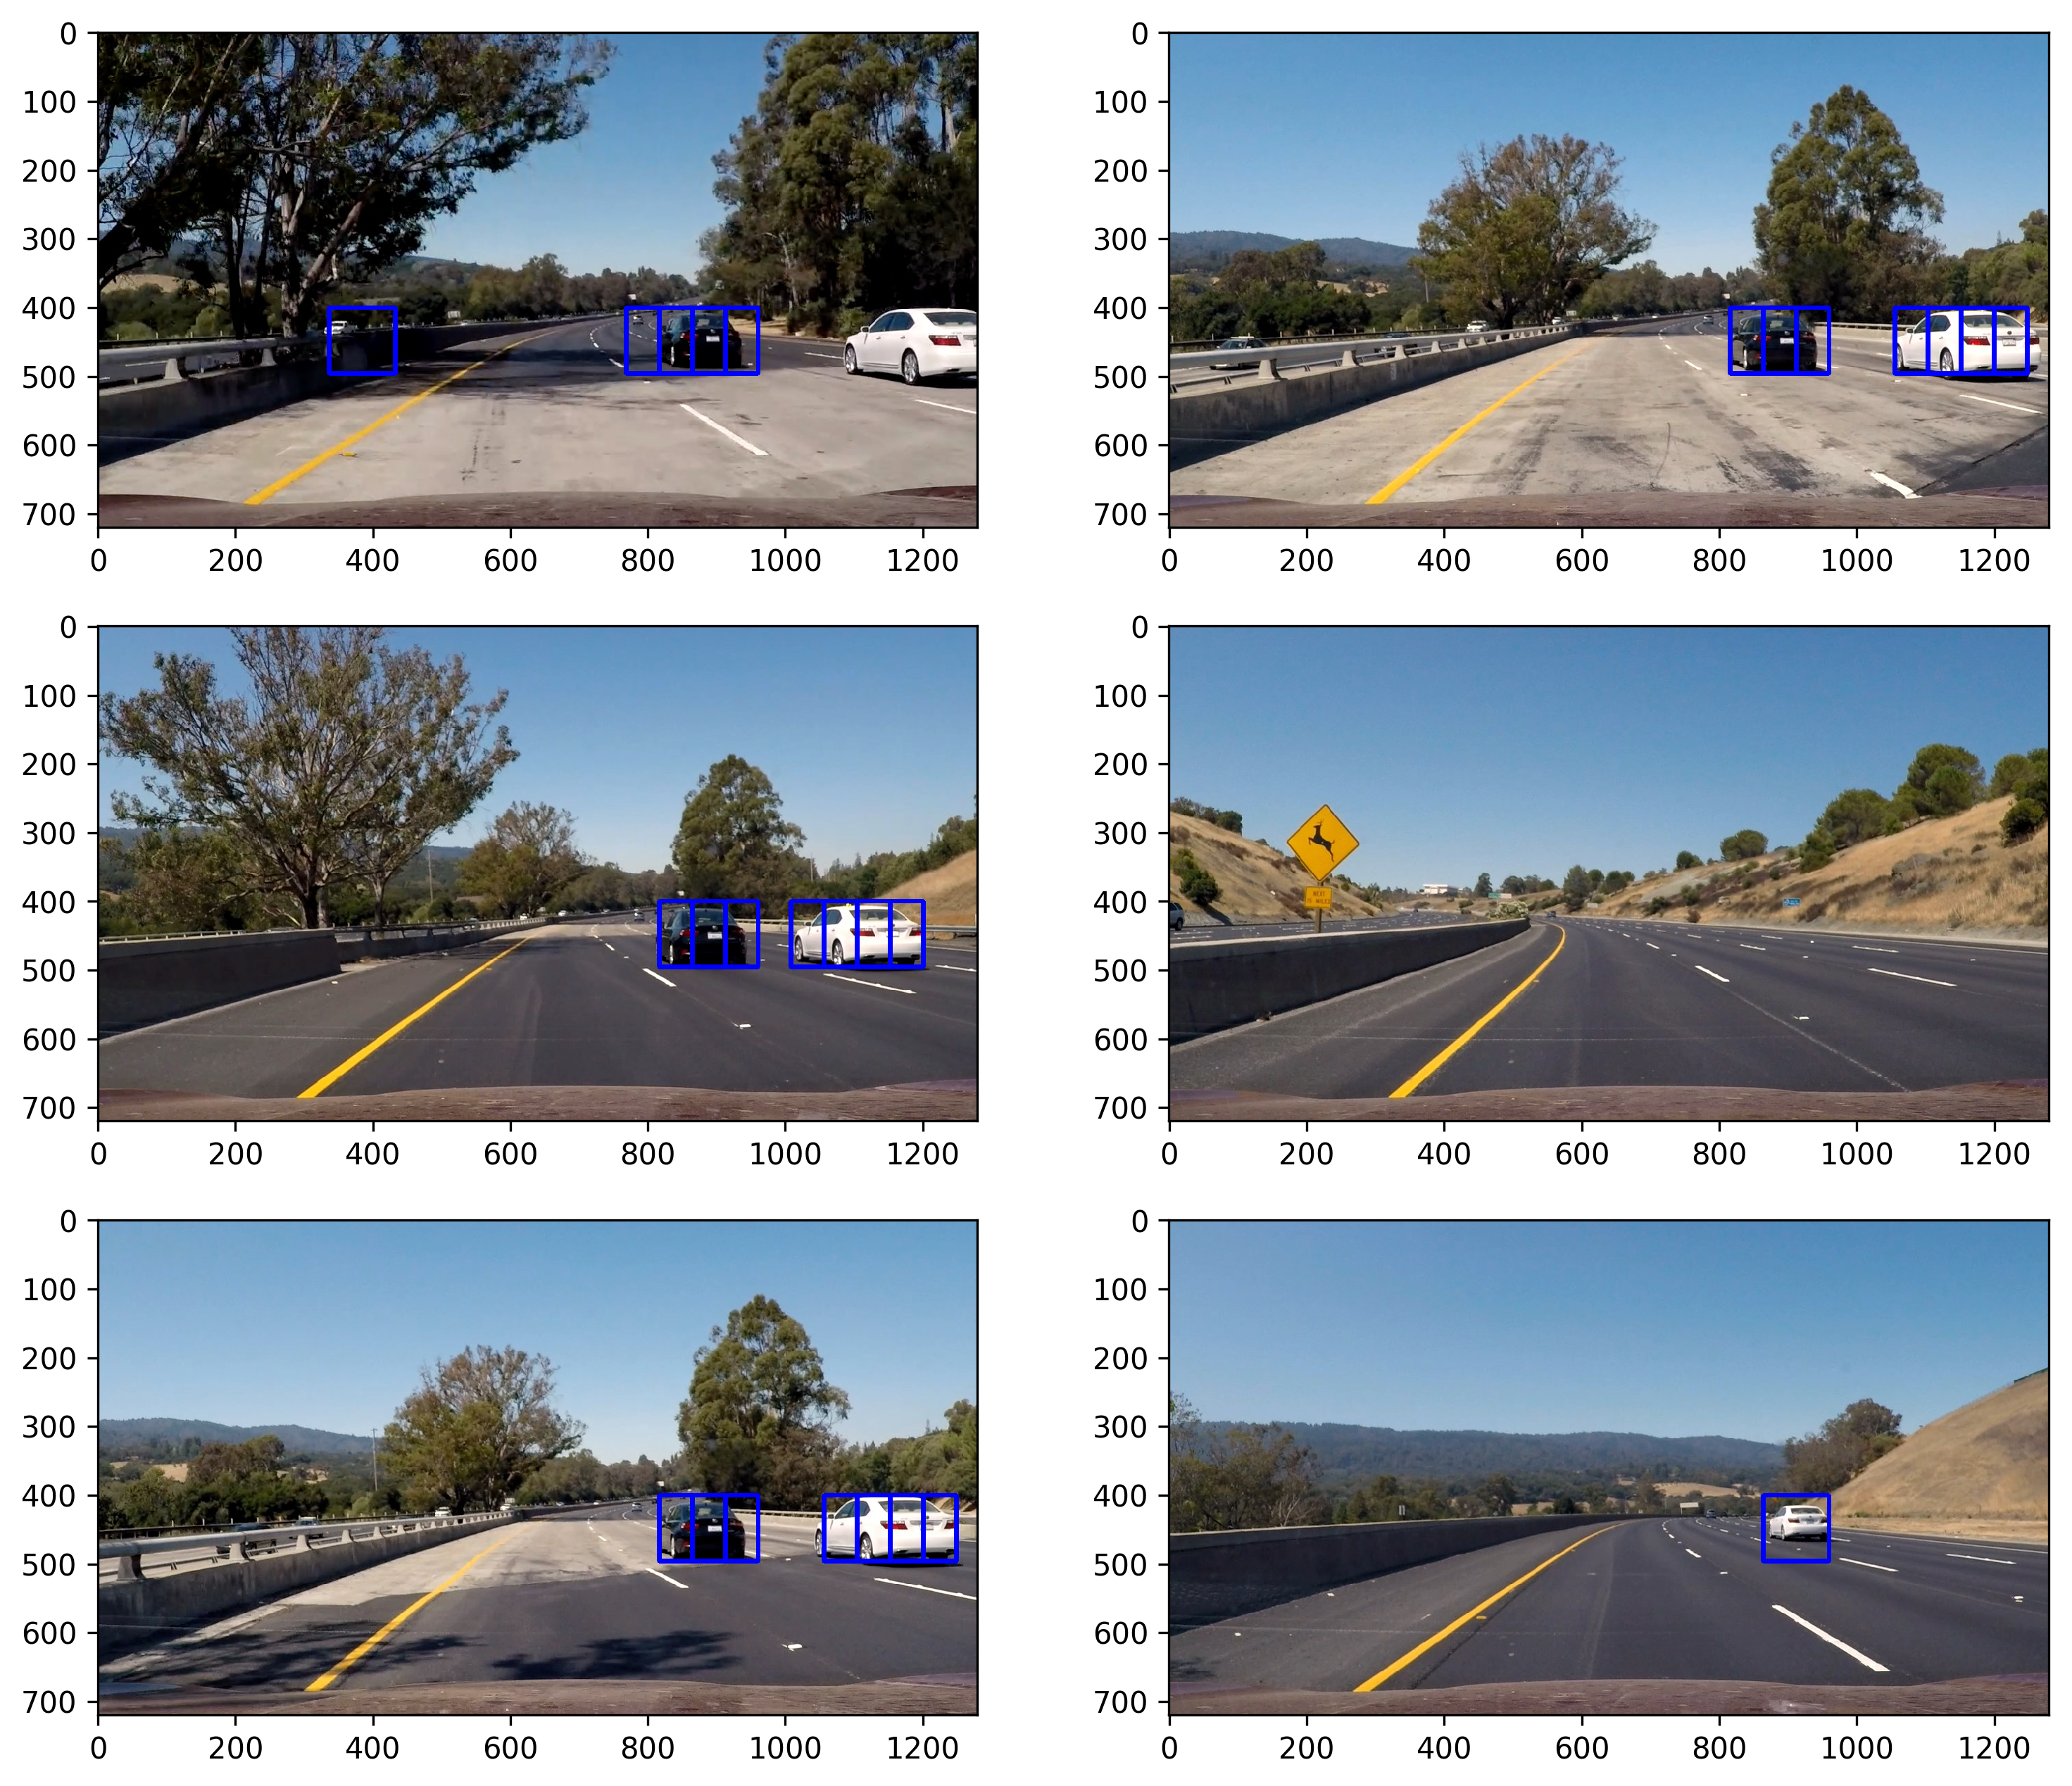

In [6]:
example_images = glob.glob("test_images/*")

images = []
titles = []
y_start_stop = [400, 656] # [None, None]
overlap = 0.5

for image in example_images:
    t1 = time.time()
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(overlap, overlap))
    
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channels=hog_channels, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                 hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image out of ',len(windows),' windows')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

In [7]:
# for i in range(len(images)):
#     cv2.imwrite('output_images/sample_outputs/param_set1/image'+str(i)+'.jpg', images[i])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.5942189693450928 seconds to run, total windows =  294
0.6007988452911377 seconds to run, total windows =  294
0.5933270454406738 seconds to run, total windows =  294
0.5926413536071777 seconds to run, total windows =  294
0.6956191062927246 seconds to run, total windows =  294
0.5559923648834229 seconds to run, total windows =  294


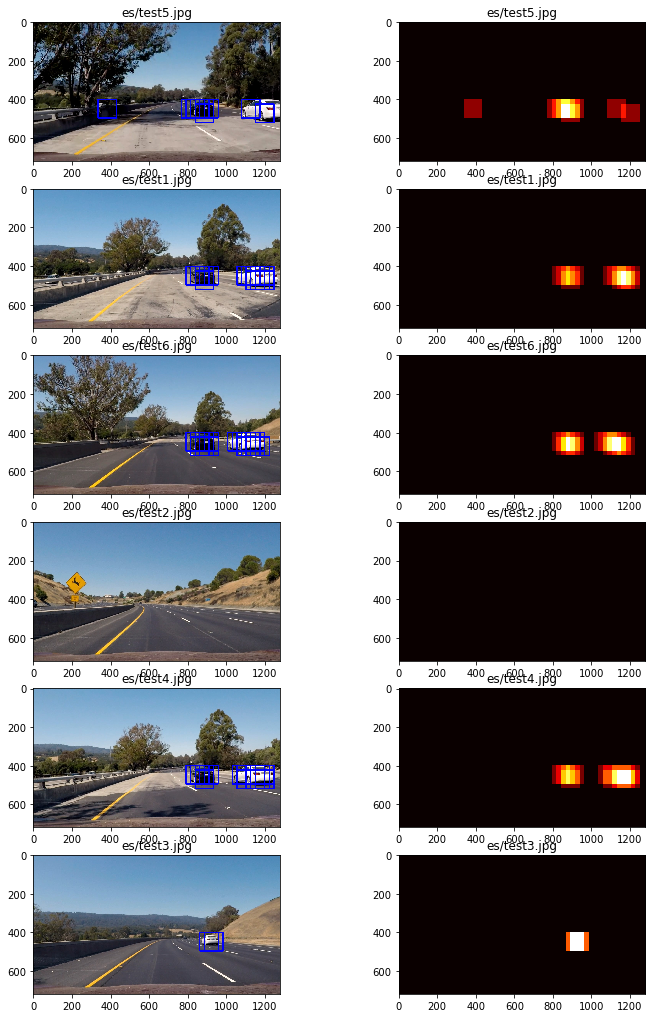

In [8]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5

example_images = glob.glob("test_images/*")

# Iterate over test images
for image in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_spaces(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            # hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
        
    print(time.time()-t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(image[-12:])
    out_titles.append(image[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [9]:
# for i in range(len(out_images)):
#     cv2.imwrite('output_images/sample_outputs/param_set1/subsampled'+str(i)+'.jpg', out_images[i])

In [10]:
# Iterate over test images
def find_cars(img, scale):
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_spaces(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            # hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

In [11]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


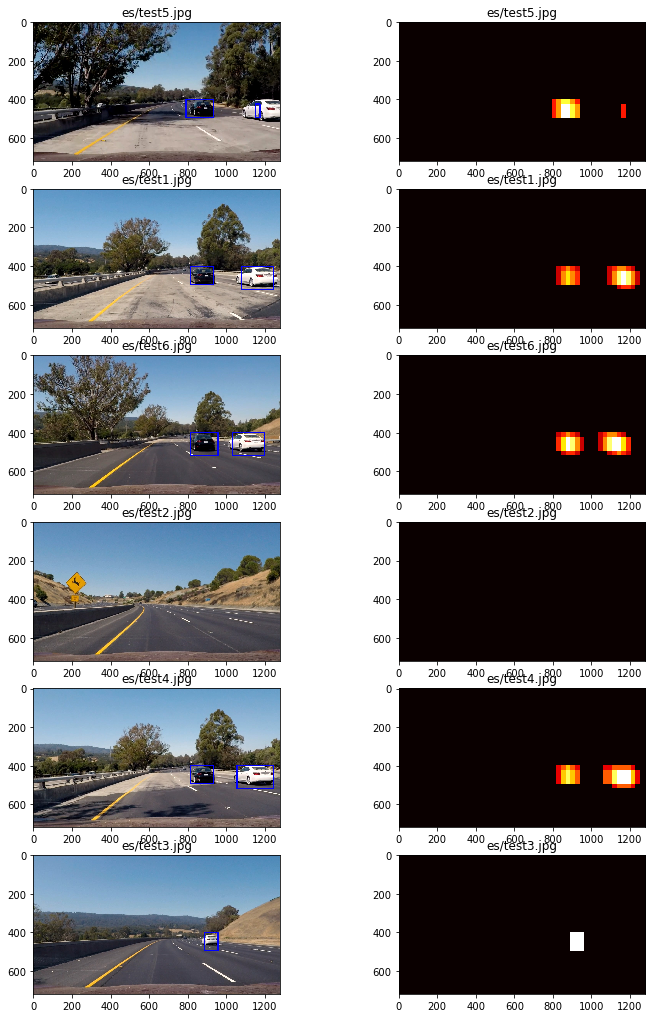

In [13]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for image in example_images:
    img = mpimg.imread(image)
    out_img, heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of an image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [14]:
# for i in range(len(out_images)):
#     cv2.imwrite('output_images/bounding_boxes/bounding'+str(i)+'.jpg', out_images[i])

In [15]:
def process_img(img):
    out_img, heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of an image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'project_output_video.mp4'
clip = VideoFileClip('project_video.mp4')
# clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(process_img)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


 84%|████████▍ | 1057/1261 [09:17<01:45,  1.93it/s]

In [17]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))